In [7]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from random import randrange
%pwd

'/Users/xsong/Desktop/Felix eggs'

In [8]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                                'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                               'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                               'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
            
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False, save_mask=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            image = image.convert('RGB')
            draw = PILImageDraw.Draw(image)
            buffer = BytesIO()
            image.save(buffer, format='PNG')
            buffer.seek(0)
            data_uri = base64.b64encode(buffer.read()).decode('ascii')
            image_path = "data:image/png;base64,{0}".format(data_uri)
            
        if image_id not in self.segmentations.keys():
            print("No Mask Image found")
            image.show()
            return None
        
        # Calculate the size and adjusted display size
        max_width = 1024
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        self.polygons_no_scale = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            polygons_list_no_scale = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    polygons_list_no_scale.append(segmentation_points)
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            self.polygons_no_scale[segm['id']] = polygons_list_no_scale
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
        
        # Draw segmentation polygons on image
        html  = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in self.polygons_no_scale.items():
                v = '#%02x%02x%02x' % (randrange(0,255),randrange(0,255),randrange(0,255))
                draw.polygon(points_list[0],fill=v)
                if save_mask:
                    print(points_list[0])
            image.show()
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
            
            
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)


In [9]:
annotation_path = './training images_zeynep/all_json.json'
image_dir = './training images_zeynep'
coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info:
  contributor: 
  date_created: 
  description: 
  url: 
  version: 
  year: 
ERROR: year should be type <class 'int'>

Licenses:
  name: 
  id: 0
  url: 


Categories:
  super_category: 
    id 1: egg



# Change image_id to generate other images and masks in the same folder
# Then run the next section

Image:
  id: 1
  width: 3384
  height: 1820
  file_name: 1.tif
  license: 0
  flickr_url: 
  coco_url: 
  date_captured: 0
  segmentations (102):
    1:blue:{'id': 1, 'name': 'egg', 'supercategory': ''}
    2:purple:{'id': 1, 'name': 'egg', 'supercategory': ''}
    3:red:{'id': 1, 'name': 'egg', 'supercategory': ''}
    4:green:{'id': 1, 'name': 'egg', 'supercategory': ''}
    5:orange:{'id': 1, 'name': 'egg', 'supercategory': ''}
    6:salmon:{'id': 1, 'name': 'egg', 'supercategory': ''}
    7:pink:{'id': 1, 'name': 'egg', 'supercategory': ''}
    8:gold:{'id': 1, 'name': 'egg', 'supercategory': ''}
    9:orchid:{'id': 1, 'name': 'egg', 'supercategory': ''}
    10:slateblue:{'id': 1, 'name': 'egg', 'supercategory': ''}
    11:limegreen:{'id': 1, 'name': 'egg', 'supercategory': ''}
    12:seagreen:{'id': 1, 'name': 'egg', 'supercategory': ''}
    13:darkgreen:{'id': 1, 'name': 'egg', 'supercategory': ''}
    14:olive:{'id': 1, 'name': 'egg', 'supercategory': ''}
    15:teal:{'id': 1, '


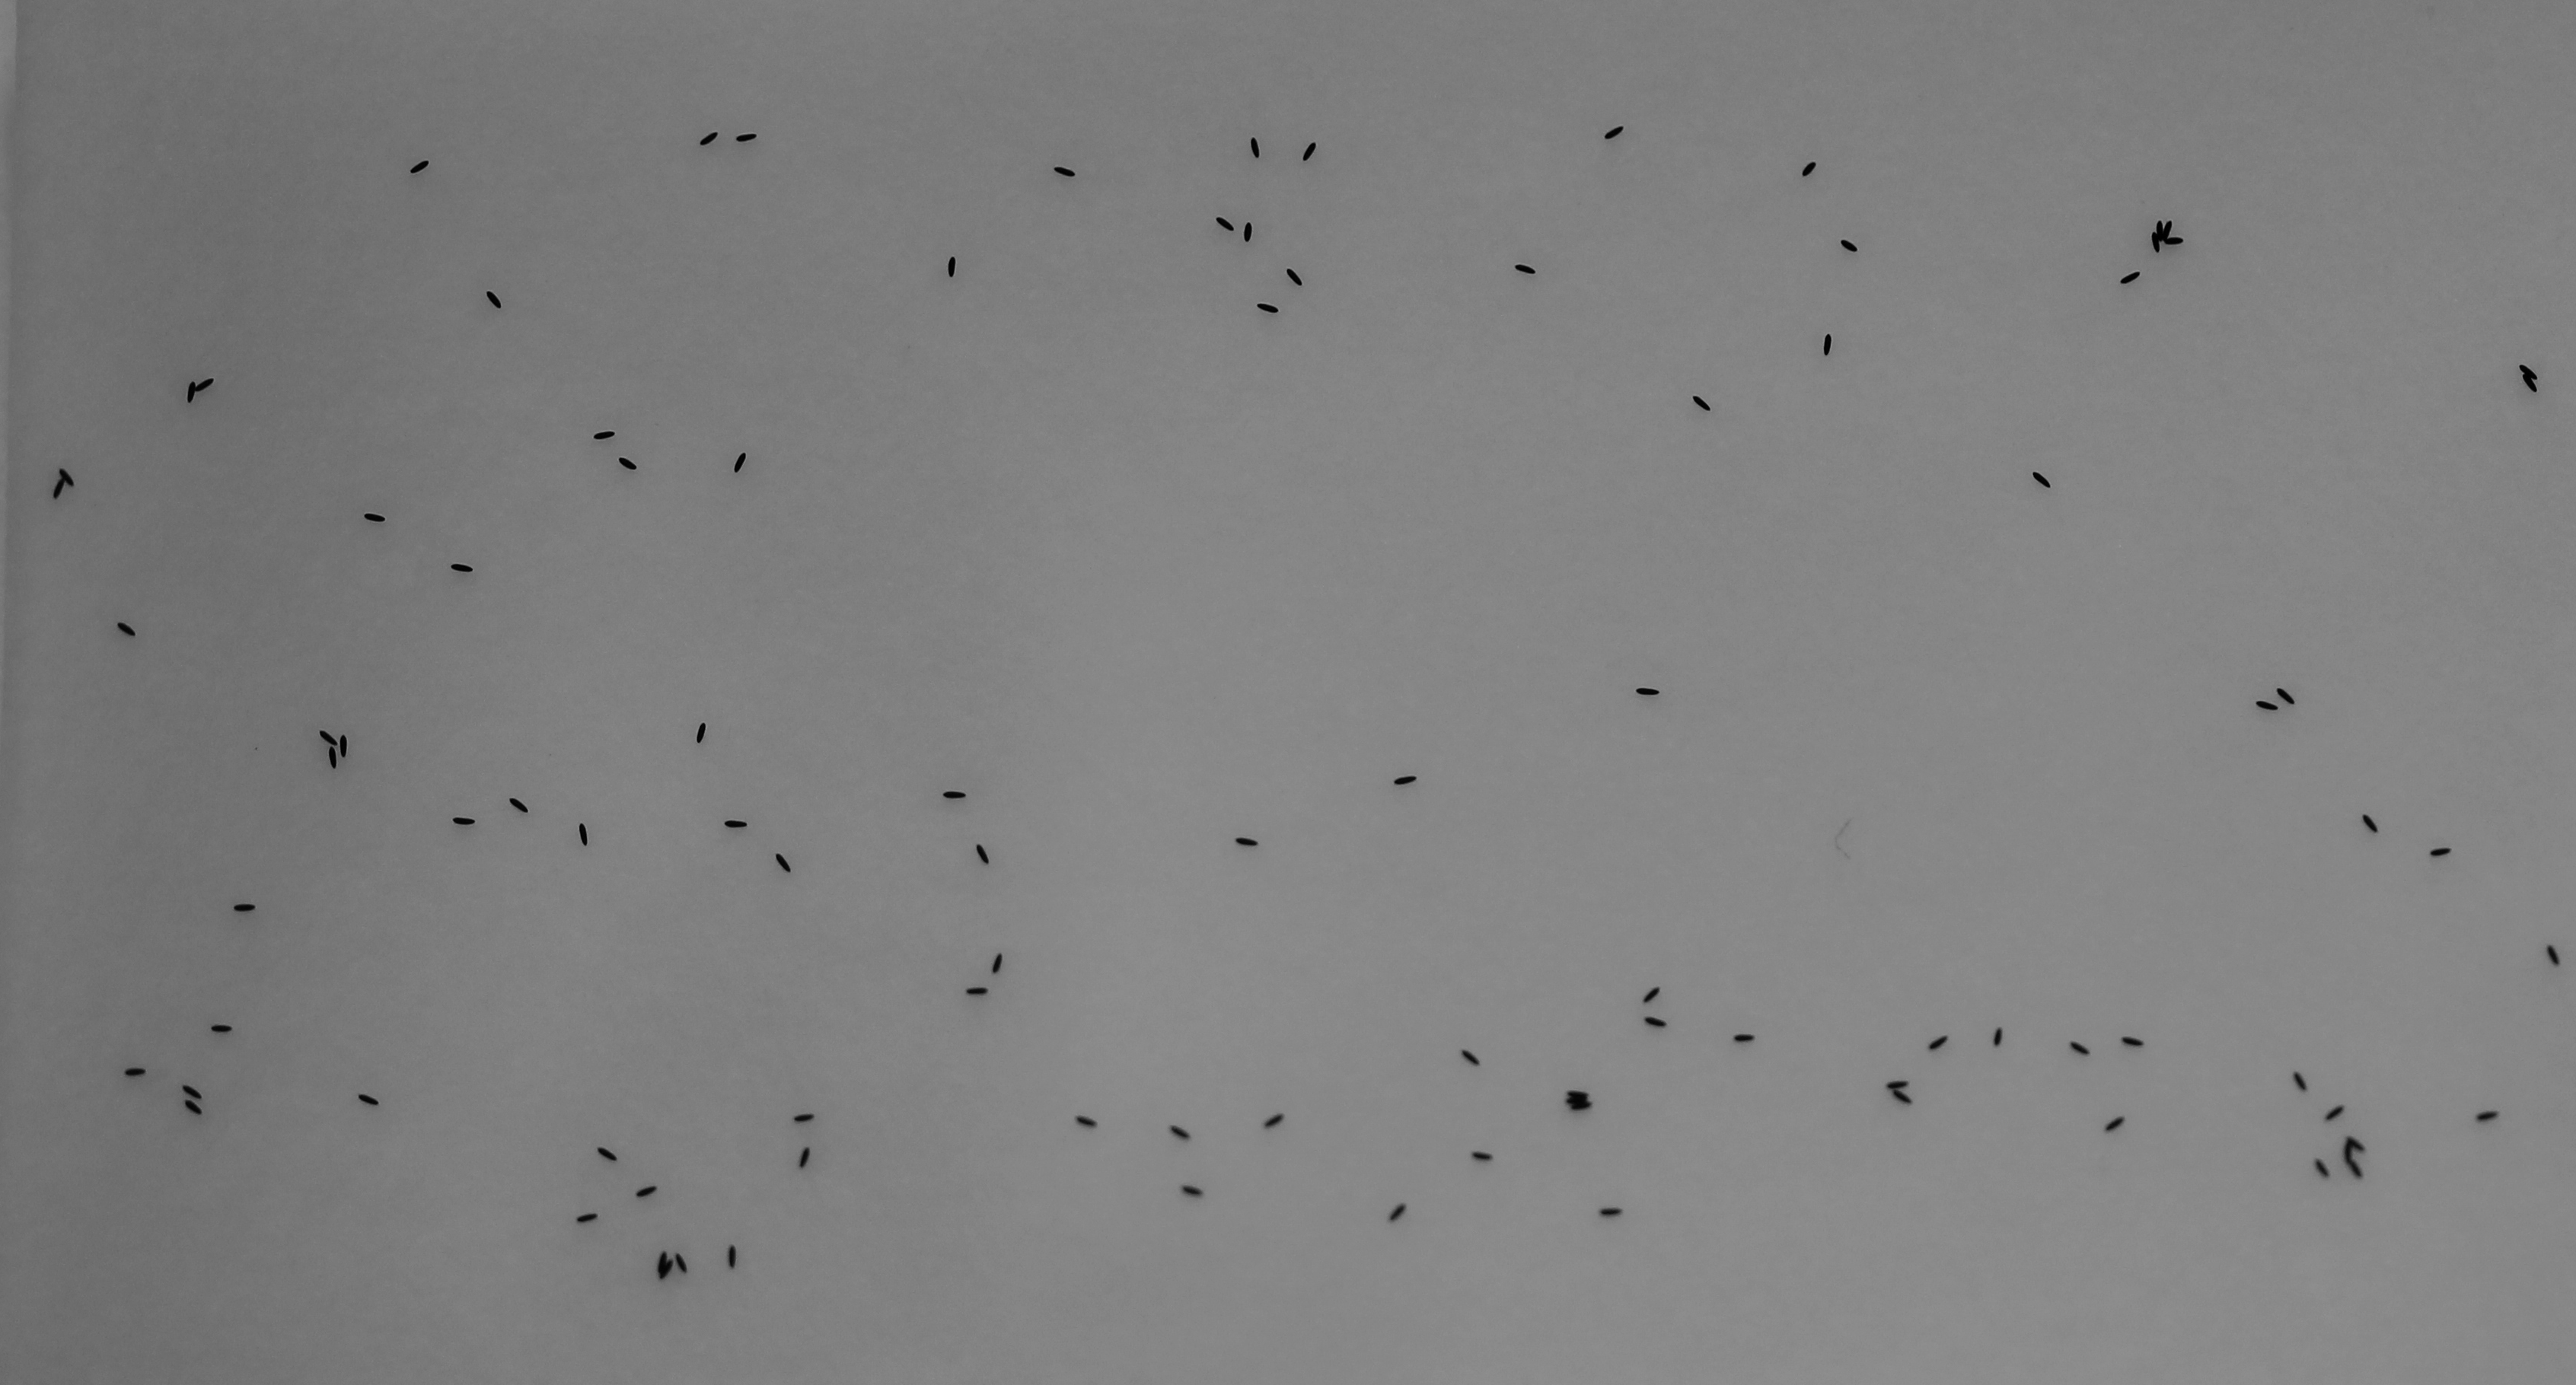

In [10]:
image_id = 1
html = coco_dataset.display_image(image_id, use_url=False,show_polys=True,show_bbox=False)
IPython.display.HTML(html)


# MASK-RCNN Mask saved separately


In [6]:
image = coco_dataset.images[image_id]
image_file_name = image['file_name']
base = os.path.basename(image_file_name)
image_name_no_changeble = os.path.splitext(base)[0]

image_path = os.path.join(coco_dataset.image_dir, image_file_name)
image = PILImage.open(image_path)
draw = PILImageDraw.Draw(image)
image_width, image_height = image.size
trainning_image_dir = os.path.join(coco_dataset.image_dir,"stage_train_mrcn")

#########################################################################
from itertools import product
l = image_width
h = image_height
num_parts = 6
part_duration = l // num_parts
parts = []
# I rearranged this a bit too
for i in range(0, l, part_duration):
    if i+part_duration > l:
        part = [l-part_duration, l]
    else: 
        part = [i, i+part_duration]
    parts.append(part)
parts_l = parts

num_parts = 4
part_duration = h // num_parts
parts = []
# I rearranged this a bit too
for i in range(0, h, part_duration):
    if i+part_duration > h:
        part = [h-part_duration, h]
    else: 
        part = [i, i+part_duration]
    parts.append(part)
parts_h = parts

C = list(product(parts_l, parts_h))
for txy in C:
    x0 = txy[0][0]
    x1 = txy[0][1]
    y0 = txy[1][0]
    y1 = txy[1][1]
    s = str(x0)+'_'+str(y0)+('_')+str(x1)+'_'+str(y1)
    #print(s)

#########################################################################

print(image_path)
for seg_id, points_list in coco_dataset.polygons_no_scale.items():
    cropped_x0 = 0
    cropped_y0 = 0
    cropped_size = (0,0)    
    points_list_0 = points_list[0]
    first_point_x = points_list_0[0]
    first_point_y = points_list_0[1]
    for txy in C:
        x0 = txy[0][0]
        x1 = txy[0][1]
        y0 = txy[1][0]
        y1 = txy[1][1]
        for xx,yy in zip(points_list_0[0::2], points_list_0[1::2]):
            if(xx >= x0 and xx < x1 and yy >= y0 and yy < y1 ) : 
                # save image if it's never saved
                image_name = image_name_no_changeble + '_' + str(x0)+'_'+str(y0)+('_')+str(x1)+'_'+str(y1)
                image_mask_name = image_name+'_'+str(int(xx))+'_'+str(int(yy))
                #print(image_mask_name)
                image_folder = os.path.join(trainning_image_dir,image_name,"images")
                image_b_folder = os.path.join(trainning_image_dir,image_name,"masks")
                area = (x0, y0, x1, y1)
                cropped_x0 = x0
                cropped_y0 = y0
                cropped_img = image.crop(area)
                cropped_size = cropped_img.size
                if not os.path.isdir(image_folder):
                    cropped_img.convert("LA")
                    os.makedirs(image_folder,exist_ok = True)
                    crop_img_path = os.path.join(image_folder,image_name)
                    cropped_img.save(crop_img_path+'.png','PNG')
                    #print(image_name)

                image_l = PILImage.new('L',cropped_size)
                image_b = PILImageDraw.Draw(image_l)
                list_shift = []
                for xp,yp in zip(points_list_0[0::2], points_list_0[1::2]):
                    list_shift.append(xp-x0)
                    list_shift.append(yp-y0)
                    #print(str(i), '+', str(k), '=', str(i+k)) 
                image_b.polygon(list_shift, fill ="#ffffff")
                #image_l.show()
                if not os.path.isdir(image_b_folder):
                    os.makedirs(image_b_folder,exist_ok=True)
                #print(image_b_folder)
                crop_img_b_name = os.path.join(image_b_folder,image_mask_name)
                image_l.save(crop_img_b_name+'.png','PNG')
                if first_point_x != xx and first_point_y != yy:
                    print('part of polygon fell into image : '+crop_img_b_name)
                break
            

./training images_zeynep/1.tif
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_1692_910_2256_1365/masks/1_1692_910_2256_1365_2176_910
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_2256_910_2820_1365/masks/1_2256_910_2820_1365_2547_1364
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_2256_910_2820_1365/masks/1_2256_910_2820_1365_2621_1363
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_2256_1365_2820_1820/masks/1_2256_1365_2820_1820_2811_1365
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_2256_0_2820_455/masks/1_2256_0_2820_455_2395_454
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_1128_0_1692_455/masks/1_1128_0_1692_455_1691_362
part of polygon fell into image : ./training images_zeynep/stage_train_mrcn/1_2820_910_3384_1365/masks/1_2820_910_3384_1365_3004_910
part of polygon fell into image : ./training 